In [0]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import pandas as pd
import importlib
from torch.utils.data.sampler import SubsetRandomSampler

from IPython.core.ultratb import AutoFormattedTB

__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
!rm -rf CS601R_Final_Project/ models/ datasets/ notebooks/
!git clone https://github.com/webMan1/CS601R_Final_Project.git
!cp -r CS601R_Final_Project/* .

Cloning into 'CS601R_Final_Project'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 34 (delta 10), reused 30 (delta 6), pack-reused 0
Unpacking objects: 100% (34/34), done.


In [0]:
import models.ResNetDecoder
import importlib

models.ResNetDecoder = importlib.reload(models.ResNetDecoder)

# Define Datasets and Loaders

In [0]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

class EncodedCelebADataset(Dataset):
    '''
    one of target_col_idx or target should be supplied:
        target_col_idx specifies the column index from the attributes to use as the label
        target specifies a target that spans multiple columns
    '''
    def __init__(self, data_root, split='train', target_col_idx=None, target=None):
        split_map = {
            "train": 0,
            "valid": 1,
        }

        assert split in split_map
        assert (target_col_idx or target) and not (target_col_idx and target)
        if target:
            assert target in ['hair']

        splits = pd.read_csv(os.path.join(data_root, "list_eval_partition.txt"), delim_whitespace=True, header=None, index_col=0)
        attr = pd.read_csv(os.path.join(data_root, "list_attr_celeba.txt"), delim_whitespace=True, header=1)
        mask = splits[1] == split_map[split]

        if target_col_idx:
            print(f'Using the {attr.columns[target_col_idx]} attribute as the label')
            self.labels = torch.as_tensor(attr[mask].values[:, target_col_idx])
            # self.labels = self.labels.reshape(-1, 1)
        else:
            # TODO: probably should do some argmax or something
            print(f'Using a group of columns to represent {target}')
            if target == 'hair':
                # bald, black_hair, blonde_hair, brown_hair, gray_hair, receding_hairline
                col_idxs = [4, 8, 9, 11, 17, 28]
            self.labels = torch.as_tensor(attr[mask].values[:, col_idxs])
        self.labels = (self.labels + 1) // 2 # changes it from -1,1 to 0,1
        print(self.labels.shape)
        print(f"Mask shape: {mask.shape}")
        self.encodings = torch.load(os.path.join(data_root, f'{split}_encodings.pt'))

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, i):
      try:
        return self.encodings[i], self.labels[i]
      except:
        import pdb; pdb.set_trace()
        raise

In [0]:
def get_loader(is_training:bool, batch_size:int):
  target_cols = list(range(40)) # I'm pretty sure there should be 40 columns..,
  dataset =  EncodedCelebADataset("/content/gdrive/My Drive/SimCLR/data/celeba", split="train" if is_training else "valid", target_col_idx=target_cols)
  return DataLoader(dataset, batch_size=batch_size, shuffle=is_training)

# Define the decoder

In [0]:
class CLRDecoder(nn.Module):
  def __init__(self, single_output=True):
    super(CLRDecoder, self).__init__()
    self.adapter = nn.Sequential(
        # nn.ReLU(),
        nn.Linear(2048, 40),
        # nn.ReLU()
    )
    # self.decoder = models.ResNetDecoder.ResNetDecoder(single_output=single_output)
    self.net = nn.Sequential(self.adapter)
  
  def forward(self, x):
    return self.net(x)

# Training Loop

In [0]:
def train(model, optimizer, train_loader, valid_loader, num_epochs:int, single_output:bool, valid_freq:int=10):
  train_len = len(train_loader)
  valid_len = len(valid_loader)
  loop = tqdm(total=(num_epochs * train_len + (num_epochs // valid_freq) * valid_len), position=0)

  train_losses = []
  train_accs = []
  train_faccs = []

  valid_losses = []
  valid_accs = []
  valid_faccs = []

  criteria = nn.BCEWithLogitsLoss() if single_output else nn.CrossEntropyLoss()

  sigmoid = nn.Sigmoid()

  for e in range(num_epochs):
    loss_builder = []
    acc_builder = []
    facc_builder = []

    for i, (x, y_truth) in enumerate(train_loader):
      x, y_truth = x.cuda(async=False), y_truth.cuda(async=False)

      optimizer.zero_grad()
      
      if single_output:
        y_truth = y_truth.float()

      else:
        y_truth = y_truth.long()
      
      y_hat = model(x)

      if single_output:
        # import pdb; pdb.set_trace()
        total_loss = criteria(y_hat, y_truth)
        total_loss.backward()
        y_hat_probs = sigmoid(y_hat)
        acc = (y_truth.eq(y_hat_probs >= 0.5).sum(dim=1) == 40).sum().item() / len(y_truth)
        facc = y_truth.eq(y_hat_probs >= 0.5).sum().item() / y_truth.numel()
        optimizer.step()

      else:
        # import pdb; pdb.set_trace()
        # y_hat is an array of tensors, with total shape of F x B x 2
        # y_truth is a tensor of shape of B x F
        # we need to iterate over the F dimension.
        losses = []
        for i in range(y_truth.shape[1]):
          loss = criteria(y_hat[i], y_truth[:,i])
          losses.append(loss)
        # for l, o in zip(losses, optimizer[1:]):
          # l.backward(retain_graph=True)
          # o.step()
        
        # Update the ResNet
        total_loss = sum(losses)
        total_loss.backward()
        optimizer.step()
        
        # import pdb; pdb.set_trace()
        acc = (y_truth.eq(torch.argmax(torch.stack(y_hat, dim=0), dim=2).permute(1, 0)).sum(dim=1) == 40).sum().item() / y_truth.shape[0]
        facc = y_turth.eq(torch.argmax(torch.stack(y_hat, dim=0), dim=2).permute(1, 0)).sum().item() / y_truth.numel()

      loss_builder.append(total_loss.item())
      acc_builder.append(acc)
      facc_builder.append(facc)

      loop.update(1)
      loop.set_description(f"Epoch: {e}, it: {i}/{train_len}. Loss: {total_loss.item()}. Acc: {acc}")
    
    train_accs.append(acc_builder)
    train_losses.append(loss_builder)
    train_faccs.append(facc_builder)

    if e % valid_freq == 0:
      loss_builder = []
      acc_builder = []
      facc_builder = []

      with torch.no_grad():
        model.eval()

        for i, (x, y_truth) in enumerate(train_loader):
          x, y_truth = x.cuda(async=False), y_truth.cuda(async=False)

        if single_output:
          y_truth = y_truth.float()
        else:
          y_truth = y_truth.long()
          
        y_hat = model(x)

        if single_output:
          total_loss = criteria(y_hat, y_truth)
          y_hat_probs = sigmoid(y_hat)
          acc = (y_truth.eq(y_hat_probs >= 0.5).sum(dim=1) == 40).sum().item() / len(y_truth)
          facc = y_truth.eq(y_hat_probs >= 0.5).sum().item() / y_truth.numel()
        else:
          # y_hat is an array of tensors, with total shape of F x B x 2
          # y_truth is a tensor of shape of B x F
          # we need to iterate over the F dimension.
          losses = []
          for i in range(y_truth.shape[1]):
            loss = criteria(y_hat[i], y_truth[:,i])
            losses.append(loss)

          # Update the ResNet
          total_loss = sum(losses)

          acc = (y_truth.eq(torch.argmax(torch.stack(y_hat, dim=0), dim=2).permute(1, 0)).sum(dim=1) == 40).sum().item() / y_truth.shape[0]
          facc = y_turth.eq(torch.argmax(torch.stack(y_hat, dim=0), dim=2).permute(1, 0)).sum().item() / y_truth.numel()

        loss_builder.append(total_loss.item())
        acc_builder.append(acc)
        facc_builder.append(facc)

        loop.update(1)
        loop.set_description(f"[VALIDATING] Epoch: {e}, it: {i}/{valid_len}. Loss: {total_loss.item()}. Acc: {acc}")

      model.train()

      valid_accs.append(acc_builder)
      valid_losses.append(loss_builder)
      valid_faccs.append(facc_builder)
    
    state = {
        "model": model.state_dict(),
        "train_losses": train_losses,
        "train_accs": train_accs,
        "train_faccs": train_faccs,
        "valid_losses": valid_losses,
        "valid_accs": valid_accs,
        "valid_faccs": valid_faccs,
        "epoch": e
    }
    num = ((e + 4) // 5) * 5
    path = f"/content/gdrive/My Drive/SimCLR/models/CelebA/clr_single_{single_output}_e_{num}_linear.mod"
    torch.save(state, path)

  return train_losses, train_accs, valid_losses, valid_accs

In [0]:
def run_training(single_output=False):
  batch_size = 64 if single_output else 64
  model = CLRDecoder(single_output=single_output).cuda()
  optimizer = optim.Adam(model.parameters())

  train_loader = get_loader(True, batch_size)
  valid_loader = get_loader(False, batch_size)

  train_losses, train_accs, valid_losses, valid_accs = train(model, optimizer, train_loader, valid_loader, num_epochs=11, single_output=single_output, valid_freq=10)

  return train_losses, train_accs, valid_losses, valid_accs, valid_faccs

In [32]:
res = run_training(True)
# rest2 = run_training(False)

Using the Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object') attribute as the label
torch.Size([162770, 40])
Mask shape: (202599,)
Using the Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eye

[VALIDATING] Epoch: 10, it: 2543/311. Loss: 0.23037979006767273. Acc: 0.05555555555555555:  99%|█████████▉| 27986/28295 [02:17<00:01, 204.99it/s]

NameError: ignored

In [0]:
train_losses, train_accs, valid_losses, valid_accs = res

In [0]:
valid_accs

[[0.05555555555555555]]

# Test Results

In [0]:
def show_res(single:bool, epoch:int, suffix:str):
  save_loc = f"/content/gdrive/My Drive/SimCLR/models/CelebA/clr_single_{single}_e_{epoch}{suffix}.mod"
  state = torch.load(save_loc)
  
  epoch = state["epoch"]
  
  train_losses, train_accs, train_faccs = state["train_losses"], state["train_accs"], state["train_faccs"]
  valid_losses, valid_accs, valid_faccs = state["valid_losses"], state["valid_accs"], state["valid_faccs"]

  train_loss_averages = [ np.mean(l) for l in train_losses]
  valid_loss_averages = [ np.mean([i for i in l]) for l in valid_losses]

  train_acc_averages = [ np.mean([i for i in l]) for l in train_accs]
  valid_acc_averages = [ np.mean([i for i in l]) for l in valid_accs]

  train_facc_averages = [ np.mean([i for i in l]) for l in train_faccs]
  valid_facc_averages = [ np.mean([i for i in l]) for l in valid_faccs]

  print(f"Got to epoch {epoch}")
  plt.plot(train_loss_averages)
  plt.plot(range(0, len(train_loss_averages), 10), valid_loss_averages)
  plt.show()

  plt.plot(train_acc_averages)
  plt.plot(range(0, len(train_acc_averages), 10), valid_acc_averages)
  plt.show()

  plt.plot(train_facc_averages)
  plt.plot(range(0, len(train_facc_averages), 10), valid_facc_averages)
  plt.show()

  return state

Got to epoch 70


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


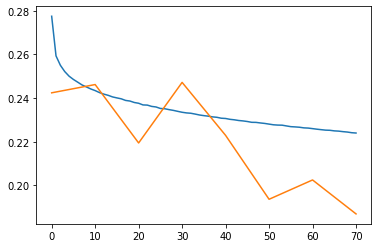

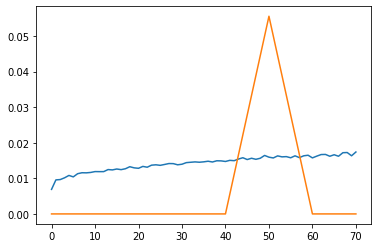

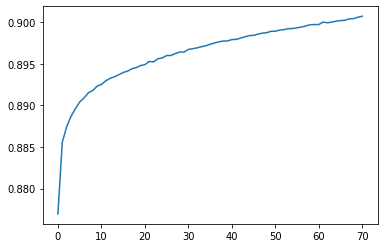

Got to epoch 10


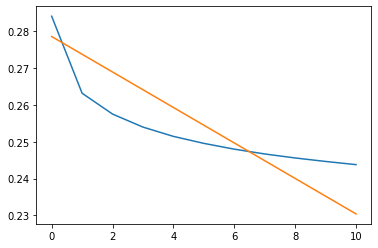

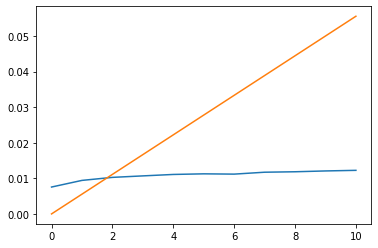

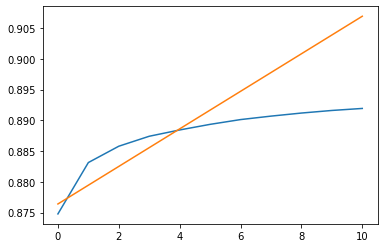

In [44]:
state = show_res(True, 70, "")
state = show_res(True, 10, "_linear")
# print(state["valid_losses"])
# state2 = show_res(False, 15)

In [42]:
loader = get_loader(False, 32)

Using the Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object') attribute as the label
torch.Size([19867, 40])
Mask shape: (202599,)


In [43]:
model = CLRDecoder(True)
model.load_state_dict(state['model'])

test_its = 100000000
sigmoid = nn.Sigmoid()

accs = []
naive_accs = []
for i, (x, y) in zip(range(test_its), loader):
  # pred = torch.stack(model(x)).permute(1, 0, 2).argmax(dim=2)
  pred = sigmoid(model(x))
  # print("Predicted:")
  # print((pred > 0.5).int().tolist())
  # print("Actual")
  # print(y.tolist())

  diff = (pred > 0.5).int().eq(y)
  acc = diff.sum().item() / diff.numel()
  accs.append(acc)

  num_tg_ones = y.sum().item()
  naive_acc = 1 - (num_tg_ones / diff.numel())
  naive_accs.append(naive_acc)
print(f"Accuracy: {np.average(accs)}")
print(f"Naive acc would be {np.average(naive_acc)}")


Accuracy: 0.8930730750879703
Naive acc would be 0.7833333333333333
